# 基于KNO求解二维Navier-Stokes

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/data_driven/mindspore_navier_stokes_KNO2D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/data_driven/mindspore_navier_stokes_KNO2D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/data_driven/navier_stokes_KNO2D.ipynb)

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）常用于复杂的仿真流程（物理建模、网格划分、数值离散、迭代求解等）和较高的计算成本，往往效率低下。因此，借助AI提升流体仿真效率是十分必要的。

近年来，随着神经网络的迅猛发展，为科学计算提供了新的范式。经典的神经网络是在有限维度的空间进行映射，只能学习与特定离散化相关的解。与经典神经网络不同，傅里叶神经算子（Fourier Neural Operator，FNO）是一种能够学习无限维函数空间映射的新型深度学习架构。该架构可直接学习从任意函数参数到解的映射，用于解决一类偏微分方程的求解问题，具有更强的泛化能力。更多信息可参考[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)。

但是这类神经算子在学习非线性PDE的长期行为时，变得不够准确和缺乏可解释性。库普曼神经算子（Koopman neural operator，KNO）通过构建方程解的非线性动力学系统，克服了这一问题。通过近似Koopman算子，一个控制动力学系统所有可能观测的无限维线性算子，作用于动力学系统的流映射，我们可以通过求解简单的线性预测问题等价地学习整个非线性PDE族的解。更多信息可参考：

- "[Koopman neural operator as a mesh-free solver of non-linear partial differential equations](https://arxiv.org/abs/2301.10022)." arXiv preprint arXiv:2301.10022 (2023).
- "[KoopmanLab: machine learning for solving complex physics equations](https://arxiv.org/abs/2301.01104)." arXiv preprint arXiv:2301.01104 (2023).

本案例教程介绍利用库普曼神经算子的纳维-斯托克斯方程（Navier-Stokes equation）求解方法。

## 纳维-斯托克斯方程（Navier-Stokes equation）

纳维-斯托克斯方程（Navier-Stokes equation）是计算流体力学领域的经典方程，是一组描述流体动量守恒的偏微分方程，简称N-S方程。它在二维不可压缩流动中的涡度形式如下：

$$
\partial_t w(x, t)+u(x, t) \cdot \nabla w(x, t)=\nu \Delta w(x, t)+f(x), \quad x \in(0,1)^2, t \in(0, T]
$$

$$
\nabla \cdot u(x, t)=0, \quad x \in(0,1)^2, t \in[0, T]
$$

$$
w(x, 0)=w_0(x), \quad x \in(0,1)^2
$$

其中$u$表示速度场，$w=\nabla \times u$表示涡度，$w_0(x)$表示初始条件，$\nu$表示粘度系数，$f(x)$为外力合力项。

## 问题描述

本案例利用Koopman Neural Operator学习某一个时刻对应涡度到下一时刻涡度的映射，实现二维不可压缩N-S方程的求解：

$$
w_t \mapsto w(\cdot, t+1)
$$

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器与损失函数。
4. 模型训练。
5. 模型推理和可视化。

## Koopman Neural Operator

Koopman Neural Operator模型构架如下图所示，包含上下两个主要分支和对应输出。图中Input表示初始涡度，上路分支通过Encoding Layer实现输入向量的高维映射，然后将映射结果作为Koopman Layer的输入，进行频域信息的非线性变换，最后由Decoding Layer将变换结果映射至最终的预测结果Prediction。同时，下路分支通过Encoding Layer实现输入向量的高维映射，然后通过Decoding Layer对输入进行重建。上下两个分支的Encoding Layer之间共享权重，Decoding Layer之间也共享权重。Prediction用于和Label计算预测误差，Reconstruction用于和Input计算重建误差。两个误差共同指导模型的梯度计算。

Encoding Layer、Koopman Layer、Decoding Layer以及两分支共同组成了Koopman Neural Operator。

Koopman Layer网络结构如虚线框所示，可重复堆叠。向量经过傅里叶变换后，经过线性变换，过滤高频信息，然后进行傅里叶逆变换；输出结果与输入相加，最后通过激活函数，得到输出向量。

![Fourier Layer网络结构](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindflow/docs/source_zh_cn/data_driven/images/kno.jpg)

In [2]:
import os
import time
import datetime
import numpy as np

import mindspore
from mindspore import nn, context, ops, Tensor, set_seed, dtype
from mindspore.nn.loss import MSELoss

from mindflow.cell import KNO2D
from mindflow.common import get_warmup_cosine_annealing_lr
from mindflow.utils import load_yaml_config

下述`src`包可以在[applications/data_driven/navier_stokes_kno/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/data_driven/navier_stokes_kno/src)下载。

In [3]:
from src.dataset import create_training_dataset
from src.trainer import NavierStokesWithLoss
from src.utils import visual

set_seed(0)
np.random.seed(0)

print("pid:", os.getpid())
print(datetime.datetime.now())

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', device_id=4)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

pid: 184534
2023-03-04 07:39:18.207815


从[config](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/data_driven/navier_stokes_kno/navier_stokes_2d.yaml)中获得模型、数据、优化器的超参。

In [4]:
config = load_yaml_config('navier_stokes_2d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]

## 创建数据集

训练与测试数据下载: [data_driven/navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/navier_stokes/dataset/) .

本案例根据Zongyi Li在 [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) 一文中对数据集的设置生成训练数据集与测试数据集。具体设置如下：

基于周期性边界，生成满足如下分布的初始条件$w_0(x)$：

$$
w_0 \sim \mu, \mu=\mathcal{N}\left(0,7^{3 / 2}(-\Delta+49 I)^{-2.5}\right)
$$

外力项设置为：

$$
f(x)=0.1\left(\sin \left(2 \pi\left(x_1+x_2\right)\right)+\right.\cos(2 \pi(x_1+x_2)))
$$

采用`Crank-Nicolson`方法生成数据，时间步长设置为1e-4，最终数据以每 t = 1 个时间单位记录解。所有数据均在256×256的网格上生成，并被下采样至64×64网格。本案例选取粘度系数$\nu=1e−5$，训练集样本量为19000个，测试集样本量为3800个。

In [5]:
# create training dataset
train_dataset = create_training_dataset(data_params, shuffle=True)
test_input = np.load(os.path.join(data_params["path"], "test/inputs.npy"))
test_label = np.load(os.path.join(data_params["path"], "test/label.npy"))
print('test_input: ', test_input.shape)
print('test_label: ', test_label.shape)

Data preparation finished
input_path:  (19000, 64, 64, 1, 1)
label_path:  (19000, 64, 64, 1, 1)
test_input:  (200, 19, 64, 64, 1, 1)
test_label:  (200, 19, 64, 64, 1, 1)


## 构建模型

网络由1层共享的Encoding Layer、多层Koopman Layer以及1层共享的Decoding Layer叠加组成：

- Encoding Layer对应样例代码中`KNO2D.enc`，将输出数据映射至高维；
- Koopman Layer对应样例代码中`KNO2D.koopman_layer`，本案例采用离散傅里叶变换实现时域与频域的转换；
- Decoding Layer对应代码中`KNO2D.dec`，获得最终的预测值。

In [6]:
model = KNO2D(in_channels=data_params['in_channels'],
              channels=model_params['channels'],
              modes=model_params['modes'],
              depths=model_params['depths'],
              resolution=model_params['resolution'],
              compute_dtype=dtype.float16 if use_ascend else dtype.float32
              )

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)

name:KNO2D_channels:20_modes:16_depths:4_resolution:64


## 优化器与损失函数

使用均方误差作为网络训练损失函数：

In [7]:
train_size = train_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["lr"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_size,
                                    warmup_epochs=1)
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               weight_decay=optimizer_params["weight_decay"])
model.set_train()
loss_fn = MSELoss()
if use_ascend:
    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')
else:
    loss_scaler = None

## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [8]:
problem = NavierStokesWithLoss(model, data_params["out_channels"], loss_fn, data_format="NHWTC")

def forward_fn(inputs, labels):
    loss, l_recons, l_pred = problem.get_loss(inputs, labels)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, l_recons, l_pred

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(inputs, labels):
    (loss, l_recons, l_pred), grads = grad_fn(inputs, labels)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        if all_finite(grads):
            grads = loss_scaler.unscale(grads)
    loss = ops.depend(loss, optimizer(grads))
    return loss, l_recons, l_pred

train_sink = mindspore.data_sink(train_step, train_dataset, sink_size=1)

summary_dir = os.path.join(config["summary_dir"], model_name)
os.makedirs(summary_dir, exist_ok=True)
print(summary_dir)

for epoch in range(1, optimizer_params["epochs"] + 1):
    time_beg = time.time()
    train_recons_full = 0.0
    train_pred_full = 0.0
    for _ in range(train_size):
        _, l_recons, l_pred = train_sink()
        train_recons_full += l_recons.asnumpy()
        train_pred_full += l_pred.asnumpy()
    train_recons_full = train_recons_full / train_size
    train_pred_full = train_pred_full / train_size
    print(f"epoch: {epoch}, time cost: {(time.time() - time_beg):>8f},"
          f" recons loss: {train_recons_full:>8f}, pred loss: {train_pred_full:>8f}")

    if epoch % config['eval_interval'] == 0:
        l_recons_all, l_pred_all = problem.test(test_input, test_label)
        print(f'Eval epoch: {epoch}, recons loss: {l_recons_all}, relative pred loss: {l_pred_all}')
        mindspore.save_checkpoint(model, ckpt_file_name=summary_dir + '/save_model.ckpt')

./summary_dir/name:KNO2D_channels:20_modes:16_depths:4_resolution:64


epoch: 1, time cost: 55.562426, recons loss: 0.467314, pred loss: 0.237300
epoch: 2, time cost: 32.804436, recons loss: 0.175188, pred loss: 0.050888
epoch: 3, time cost: 32.946971, recons loss: 0.167865, pred loss: 0.041778
epoch: 4, time cost: 33.064430, recons loss: 0.170181, pred loss: 0.038075
epoch: 5, time cost: 32.907211, recons loss: 0.171853, pred loss: 0.035849
epoch: 6, time cost: 33.799230, recons loss: 0.173322, pred loss: 0.034017
epoch: 7, time cost: 32.612255, recons loss: 0.174376, pred loss: 0.032719
epoch: 8, time cost: 32.896673, recons loss: 0.175445, pred loss: 0.031596
epoch: 9, time cost: 33.907305, recons loss: 0.176131, pred loss: 0.030644
epoch: 10, time cost: 33.175130, recons loss: 0.176701, pred loss: 0.029969
Eval epoch: 10, recons loss: 0.23137304687500002, relative pred loss: 0.03798459614068269

...

epoch: 41, time cost: 32.962233, recons loss: 0.185430, pred loss: 0.017872
epoch: 42, time cost: 33.296847, recons loss: 0.185595, pred loss: 0.017749
e

## 模型推理和可视化

取1个样本做连续10步预测，并可视化。

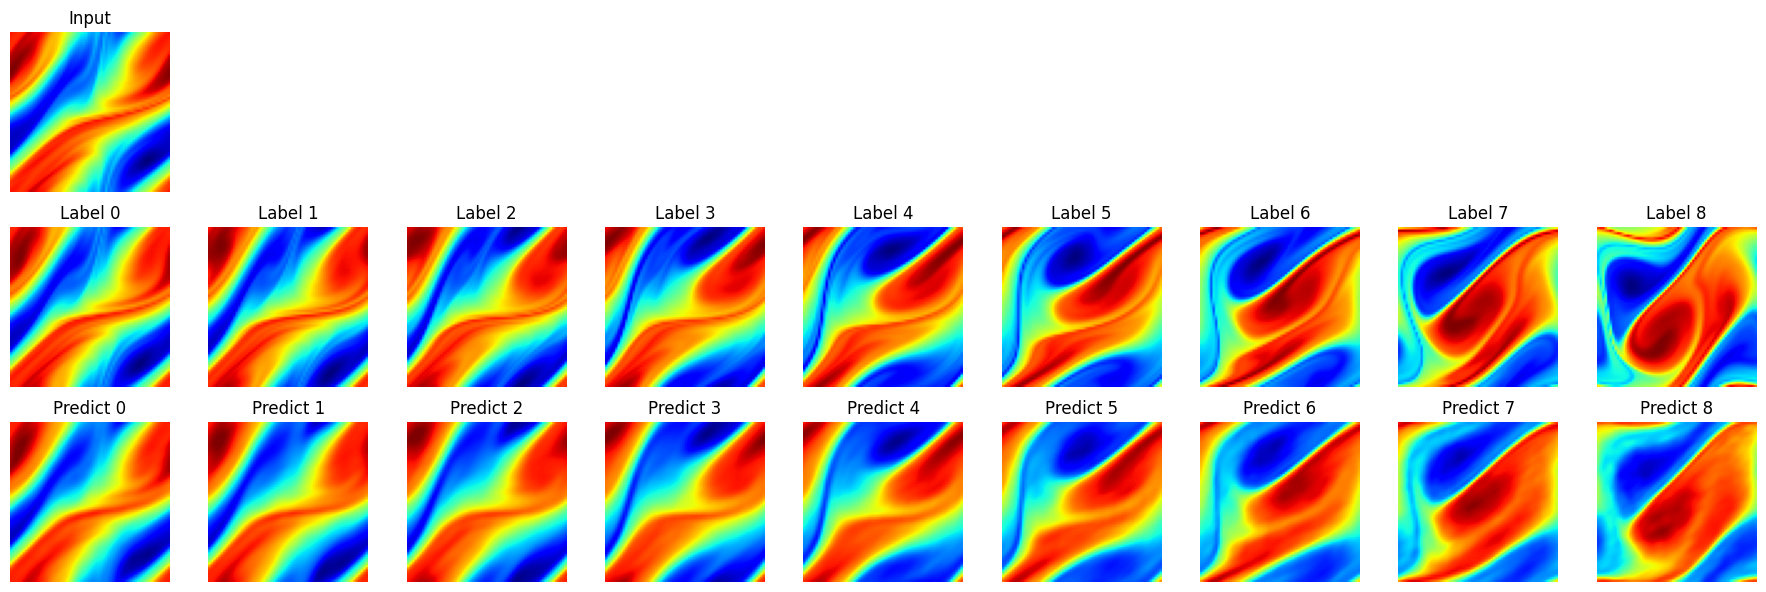

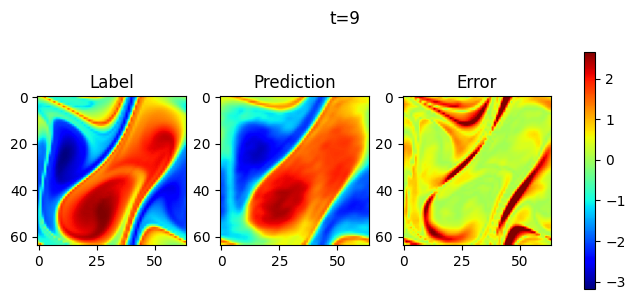

In [13]:
# Infer and plot some data.
visual(problem, test_input, test_label, t_out=10)